In [9]:
import torch
from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.utils.data import DataLoader
import json
import os


In [2]:
class AnimalsDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transforms=None):
        with open(annotations_file, 'r') as f:
            self.coco = json.load(f)
        self.img_dir = img_dir
        self.transforms = transforms
        self.images = self.coco['images']
        self.annotations = self.coco['annotations']

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_info = self.images[idx]
        img_path = os.path.join(self.img_dir, img_info['file_name'])
        image = read_image(img_path).float() / 255.0  # Normalizar a [0,1]
        
        # Obtener anotaciones
        annots = [a for a in self.annotations if a['image_id'] == img_info['id']]
        boxes = [annot['bbox'] for annot in annots]
        labels = [annot['category_id'] for annot in annots]
        
        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64),
            "class_labels": torch.tensor(labels, dtype=torch.int64),  # Nueva clave
        }
        
        if self.transforms:
            image, target = self.transforms(image, target)
        
        return image, target



In [7]:
from transformers import YolosForObjectDetection, YolosImageProcessor

# Cargar modelo y procesador preentrenado
model = YolosForObjectDetection.from_pretrained("hustvl/yolos-tiny")
processor = YolosImageProcessor.from_pretrained("hustvl/yolos-tiny")

# Ajustar el número de clases (añade 1 para la categoría 'background')
model.num_labels = len(["cat", "chicken", "cow", "dog", "fox", "goat", "horse", "person", "racoon", "skunk"]) + 1
model.id2label = {i: label for i, label in enumerate(["background", "cat", "chicken", "cow", "dog", "fox", "goat", "horse", "person", "racoon", "skunk"])}
model.label2id = {label: i for i, label in model.id2label.items()}


In [16]:
# Congelar las capas del transformer 
# Congela todas las capas del modelo
for param in model.parameters():
    param.requires_grad = False

# Asegúrate de que las capas MLP estén entrenables
for name, param in model.named_parameters():
    if "bbox_predictor" in name or "class_labels_classifier" in name:
        param.requires_grad = True


In [17]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Entrenando: {name}")


Entrenando: class_labels_classifier.layers.0.weight
Entrenando: class_labels_classifier.layers.0.bias
Entrenando: class_labels_classifier.layers.1.weight
Entrenando: class_labels_classifier.layers.1.bias
Entrenando: class_labels_classifier.layers.2.weight
Entrenando: class_labels_classifier.layers.2.bias
Entrenando: bbox_predictor.layers.0.weight
Entrenando: bbox_predictor.layers.0.bias
Entrenando: bbox_predictor.layers.1.weight
Entrenando: bbox_predictor.layers.1.bias
Entrenando: bbox_predictor.layers.2.weight
Entrenando: bbox_predictor.layers.2.bias


In [8]:
import torch
from torch.optim import AdamW
from torch.nn.functional import cross_entropy
from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


YolosForObjectDetection(
  (vit): YolosModel(
    (embeddings): YolosEmbeddings(
      (patch_embeddings): YolosPatchEmbeddings(
        (projection): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
      (interpolation): InterpolateInitialPositionEmbeddings()
    )
    (encoder): YolosEncoder(
      (layer): ModuleList(
        (0-11): 12 x YolosLayer(
          (attention): YolosSdpaAttention(
            (attention): YolosSdpaSelfAttention(
              (query): Linear(in_features=192, out_features=192, bias=True)
              (key): Linear(in_features=192, out_features=192, bias=True)
              (value): Linear(in_features=192, out_features=192, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): YolosSelfOutput(
              (dense): Linear(in_features=192, out_features=192, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )


In [ ]:

# Configurar optimizador
# optimizer = AdamW(model.parameters(), lr=1e-6, weight_decay=1e-4)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-5, weight_decay=1e-4)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Inicializa el procesador
# processor = YolosImageProcessor.from_pretrained("hustvl/yolos-tiny")

def train_one_epoch(model, dataloader, optimizer):
    model.train()  # Aseguramos que el modelo esté en modo de entrenamiento
    total_loss = 0  # Para acumular la pérdida de cada lote

    for images, targets in dataloader:
        images = [img.to(device) for img in images]  # Mueve las imágenes al dispositivo (GPU/CPU)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]  # Mueve las etiquetas al dispositivo

        # Procesar imágenes con el procesador de YOLOS
        pixel_values = processor(images=[img.permute(1, 2, 0).cpu() for img in images], return_tensors="pt").pixel_values
        pixel_values = pixel_values.to(device)  # Mueve las imágenes procesadas al dispositivo

        # Adelante (Forward Pass)
        outputs = model(pixel_values=pixel_values, labels=targets)
        
        # Calculamos la pérdida
        loss = outputs.loss
        total_loss += loss.item()

        # Backward Pass (Cálculo de gradientes)
        loss.backward()

        # Gradient Clipping (solo en parámetros entrenables)
        torch.nn.utils.clip_grad_norm_(filter(lambda p: p.requires_grad, model.parameters()), max_norm=0.1)

        # Actualización de los parámetros del modelo
        optimizer.step()
        optimizer.zero_grad()  # Limpiar los gradientes para la próxima iteración

    return total_loss / len(dataloader)  # Retorna el promedio de la pérdida


In [55]:


train_dataset = AnimalsDataset('./animals/train/annotations.json', './animals/train')
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))


In [14]:
# Variables para el checkpoint y parada anticipada
best_loss = float('inf')  # Inicializa con un valor muy alto
initial_loss = None
stop_training = False

# Directorio para guardar los checkpoints
checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

In [21]:
# Bucle de entrenamiento con checkpoints y parada anticipada

# Bucle de entrenamiento con checkpoints, parada anticipada y scheduler
for epoch in range(50):
    if stop_training:
        print("Entrenamiento detenido debido a un aumento significativo en la pérdida.")
        break

    loss = train_one_epoch(model, train_loader, optimizer)

    # Establecer la pérdida inicial (solo en la primera época)
    if initial_loss is None:
        initial_loss = loss

    # Guardar el modelo si mejora la pérdida
    if loss < best_loss:
        best_loss = loss
        torch.save(model.state_dict(), os.path.join(checkpoint_dir, f"best_model_epoch_{epoch+1}.pth"))
        print(f"Checkpoint guardado en la época {epoch+1} con pérdida {best_loss:.4f}")

    # Detener el entrenamiento si la pérdida aumenta un 10% del valor inicial
    if loss > 1.1 * initial_loss:
        print(f"Entrenamiento detenido en la época {epoch+1}. Pérdida: {loss:.4f}, inicial: {initial_loss:.4f}")
        stop_training = True

    # Clipping de gradientes
    clip_grad_norm_(filter(lambda p: p.requires_grad, model.parameters()), max_norm=0.1)

    # Llamar al scheduler para ajustar la tasa de aprendizaje
    scheduler.step(loss)  # Reduce la tasa de aprendizaje si la pérdida no mejora

    print(f"Época {epoch+1}, Pérdida: {loss:.4f}")


Época 1, Pérdida: 3479.5174
Época 2, Pérdida: 3478.6821
Época 3, Pérdida: 3488.1321
Época 4, Pérdida: 3490.9245
Época 5, Pérdida: 3483.3563
Época 6, Pérdida: 3483.7695
Época 7, Pérdida: 3484.8456
Época 8, Pérdida: 3493.6092
Época 9, Pérdida: 3484.6230
Época 10, Pérdida: 3490.3351
Época 11, Pérdida: 3482.5959
Época 12, Pérdida: 3491.5901
Época 13, Pérdida: 3485.1300
Época 14, Pérdida: 3482.9040
Época 15, Pérdida: 3483.0677
Época 16, Pérdida: 3492.3025
Época 17, Pérdida: 3493.3504
Época 18, Pérdida: 3491.8554
Época 19, Pérdida: 3495.1609
Época 20, Pérdida: 3482.4634
Época 21, Pérdida: 3491.0392
Época 22, Pérdida: 3489.4874
Época 23, Pérdida: 3484.1637
Época 24, Pérdida: 3487.4344
Época 25, Pérdida: 3488.5154
Época 26, Pérdida: 3487.0981
Época 27, Pérdida: 3482.9094
Época 28, Pérdida: 3486.7567
Época 29, Pérdida: 3490.3674
Época 30, Pérdida: 3478.0289
Época 31, Pérdida: 3487.3253
Época 32, Pérdida: 3484.1551
Época 33, Pérdida: 3483.0841
Época 34, Pérdida: 3482.5176
Época 35, Pérdida: 3489

In [6]:
for images, targets in train_loader:
    for img, tgt in zip(images, targets):
        print("Image shape:", img.shape)  # Debería ser (3, altura, ancho)
        print("Boxes shape:", tgt['boxes'].shape)  # (n_boxes, 4)
        print("Labels shape:", tgt['labels'].shape)  # (n_boxes,)


Image shape: torch.Size([3, 416, 416])
Boxes shape: torch.Size([1, 4])
Labels shape: torch.Size([1])
Image shape: torch.Size([3, 416, 416])
Boxes shape: torch.Size([1, 4])
Labels shape: torch.Size([1])
Image shape: torch.Size([3, 416, 416])
Boxes shape: torch.Size([1, 4])
Labels shape: torch.Size([1])
Image shape: torch.Size([3, 416, 416])
Boxes shape: torch.Size([1, 4])
Labels shape: torch.Size([1])
Image shape: torch.Size([3, 416, 416])
Boxes shape: torch.Size([1, 4])
Labels shape: torch.Size([1])
Image shape: torch.Size([3, 416, 416])
Boxes shape: torch.Size([1, 4])
Labels shape: torch.Size([1])
Image shape: torch.Size([3, 416, 416])
Boxes shape: torch.Size([1, 4])
Labels shape: torch.Size([1])
Image shape: torch.Size([3, 416, 416])
Boxes shape: torch.Size([6, 4])
Labels shape: torch.Size([6])
Image shape: torch.Size([3, 416, 416])
Boxes shape: torch.Size([1, 4])
Labels shape: torch.Size([1])
Image shape: torch.Size([3, 416, 416])
Boxes shape: torch.Size([1, 4])
Labels shape: torch.

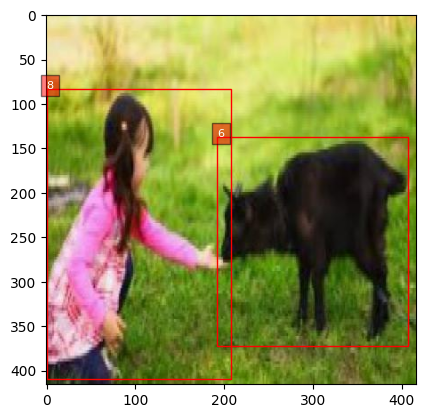

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_sample(dataset, idx):
    image, target = dataset[idx]
    fig, ax = plt.subplots(1)
    ax.imshow(image.permute(1, 2, 0).numpy())
    for box, label in zip(target["boxes"], target["labels"]):
        rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(box[0], box[1], str(label.item()), color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))
    plt.show()

visualize_sample(train_dataset, 0)


In [10]:

valid_dataset = AnimalsDataset('./animals/valid/annotations.json', './animals/valid')
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

/tmp/ipykernel_4123/1762479881.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./checkpoints/best_model_epoch_12.pth"))  # Reemplaza X

AttributeError: 'YolosObjectDetectionOutput' object has no attribute 'pred_labels'

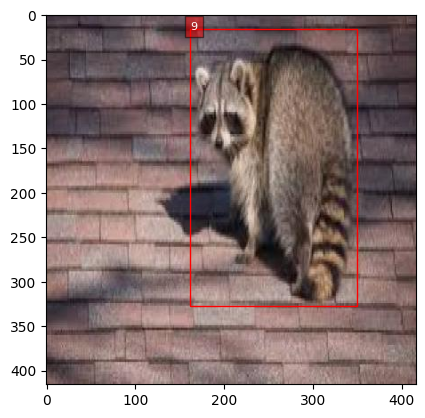

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch

# Definir la función para visualizar las inferencias
def visualize_inference(image, target, output):
    fig, ax = plt.subplots(1)

    # Mover la imagen de la GPU a la CPU y convertirla a numpy para mostrarla
    image = image.permute(1, 2, 0).cpu().numpy()  # Convierte el tensor de la imagen a numpy
    ax.imshow(image)

    # Dibujar las cajas reales (anotaciones)
    for box, label in zip(target["boxes"], target["labels"]):
        # Convierte las cajas y las etiquetas a CPU y dibuja en rojo
        box = box.cpu().numpy()  # Asegurarse de que las cajas están en la CPU
        ax.add_patch(patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=1, edgecolor='r', facecolor='none'))
        ax.text(box[0], box[1], str(label.item()), color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))
    
    # Dibujar las cajas predichas
    pred_boxes = output.pred_boxes[0].cpu().numpy()  # Convierte las cajas predichas a numpy
    pred_labels = output.pred_labels[0].cpu().numpy()  # Las etiquetas predichas
    pred_scores = output.pred_scores[0].cpu().numpy()  # Las puntuaciones de las predicciones
    
    # Solo mostrar predicciones con puntuación > 0.5
    for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
        if score > 0.5:  # Umbral de confianza
            ax.add_patch(patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=2, edgecolor='g', facecolor='none'))
            ax.text(box[0], box[1], f"{label} ({score:.2f})", color='white', fontsize=8, bbox=dict(facecolor='green', alpha=0.5))
    
    plt.show()

# Cargar el modelo entrenado
model.load_state_dict(torch.load("./checkpoints/best_model_epoch_12.pth"))  # Reemplaza X por la época
model.to(device)
model.eval()  # Poner el modelo en modo de inferencia

# Seleccionar algunas imágenes del conjunto de validación
images, targets = next(iter(valid_loader))  # Usar el DataLoader de validación

# Mover las imágenes al dispositivo
images = [img.to(device) for img in images]
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

# Realizar la inferencia
with torch.no_grad():  # No necesitamos calcular los gradientes para la inferencia
    pixel_values = processor(images=[img.permute(1, 2, 0).cpu() for img in images], return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    
    # Obtener las predicciones
    outputs = model(pixel_values=pixel_values)

# Visualizar para la primera imagen del lote
visualize_inference(images[0], targets[0], outputs)


visualizar inferencias

In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch

# Definir la función para visualizar las inferencias
def visualize_inference(image, target, output):
    fig, ax = plt.subplots(1)

    # Mover la imagen de la GPU a la CPU y convertirla a numpy para mostrarla
    image = image.permute(1, 2, 0).cpu().numpy()  # Convierte el tensor de la imagen a numpy
    ax.imshow(image)

    # Dibujar las cajas reales (anotaciones)
    for box, label in zip(target["boxes"], target["labels"]):
        # Convierte las cajas y las etiquetas a CPU y dibuja en rojo
        box = box.cpu().numpy()  # Asegurarse de que las cajas están en la CPU
        ax.add_patch(patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=1, edgecolor='r', facecolor='none'))
        ax.text(box[0], box[1], str(label.item()), color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))
    
    # Dibujar las cajas predichas
    pred_boxes = output.pred_boxes[0].cpu().numpy()  # Convierte las cajas predichas a numpy
    # pred_scores = output.scores[0].cpu().numpy()  # Las puntuaciones de las predicciones
    
    # Calcular las etiquetas predichas a partir de las puntuaciones de los logits
    pred_labels = torch.argmax(output.logits[0], dim=-1).cpu().numpy()  # Obtener las etiquetas predichas
    
    # Solo mostrar predicciones con puntuación > 0.5
    for box, label in zip(pred_boxes, pred_labels):
        # if score > 0.5:  # Umbral de confianza
        ax.add_patch(patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=2, edgecolor='g', facecolor='none'))
        # ax.text(box[0], box[1], f"{label} )", color='white', fontsize=8, bbox=dict(facecolor='green', alpha=0.5))
    
    plt.show()

# Cargar el modelo entrenado
model.load_state_dict(torch.load("./checkpoints/best_model_epoch_12.pth"))  # Reemplaza X por la época


/tmp/ipykernel_4123/3333136257.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./checkpoints/best_model_epoch_12.pth"))  # Reemplaza X

<All keys matched successfully>

In [13]:
model.to(device)
model.eval()  # Poner el modelo en modo de inferencia


YolosForObjectDetection(
  (vit): YolosModel(
    (embeddings): YolosEmbeddings(
      (patch_embeddings): YolosPatchEmbeddings(
        (projection): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
      (interpolation): InterpolateInitialPositionEmbeddings()
    )
    (encoder): YolosEncoder(
      (layer): ModuleList(
        (0-11): 12 x YolosLayer(
          (attention): YolosSdpaAttention(
            (attention): YolosSdpaSelfAttention(
              (query): Linear(in_features=192, out_features=192, bias=True)
              (key): Linear(in_features=192, out_features=192, bias=True)
              (value): Linear(in_features=192, out_features=192, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): YolosSelfOutput(
              (dense): Linear(in_features=192, out_features=192, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )


etiquetas ["cat", "chicken", "cow", "dog", "fox", "goat", "horse", "person", "racoon", "skunk"]

In [ ]:

# Seleccionar algunas imágenes del conjunto de validación
images, targets = next(iter(valid_loader))  # Usar el DataLoader de validación

# Mover las imágenes al dispositivo
images = [img.to(device) for img in images]
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

# Realizar la inferencia
with torch.no_grad():  # No necesitamos calcular los gradientes para la inferencia
    pixel_values = processor(images=[img.permute(1, 2, 0).cpu() for img in images], return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    
    # Obtener las predicciones
    outputs = model(pixel_values=pixel_values)

# Visualizar para la primera imagen del lote
visualize_inference(images[0], targets[0], outputs)


NameError: name 'valid_loader' is not defined

Calculo de error cuadratico medio

In [ ]:
import numpy as np
from collections import defaultdict

def evaluate_mse_full_dataset(model, dataloader, num_classes):
    model.eval()
    all_true_boxes = defaultdict(list)
    all_pred_boxes = defaultdict(list)

    with torch.no_grad():
        for images, targets in dataloader:
            # Mover datos al dispositivo
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            # Inferencia
            pixel_values = processor(images=[img.permute(1, 2, 0).cpu() for img in images], return_tensors="pt").pixel_values
            pixel_values = pixel_values.to(device)
            outputs = model(pixel_values=pixel_values)

            # Procesar todas las imágenes del lote
            for target, pred_boxes, logits in zip(targets, outputs.pred_boxes, outputs.logits):
                pred_boxes = pred_boxes.cpu().numpy()
                true_boxes = target["boxes"].cpu().numpy()
                pred_labels = torch.argmax(logits, dim=-1).cpu().numpy()
                # pred_scores = scores.cpu().numpy()
                true_labels = target["labels"].cpu().numpy()

                # Asociar predicciones con etiquetas reales por categoría
                for t_label, t_box in zip(true_labels, true_boxes):
                    # Agregar la caja real a la categoría correspondiente
                    all_true_boxes[t_label].append(t_box)
                    # Buscar predicciones válidas para esta etiqueta (umbral de confianza > 0.5)
                    for p_label, p_box in zip(pred_labels, pred_boxes):
                        if p_label == t_label:
                            all_pred_boxes[t_label].append(p_box)

    # Calcular el MSE por categoría
    mse_per_category = {}
    for category in range(num_classes):  # Asegúrate de incluir todas las categorías
        true_boxes = np.array(all_true_boxes.get(category, []))
        pred_boxes = np.array(all_pred_boxes.get(category, []))

        if len(true_boxes) > 0 and len(pred_boxes) > 0:
            mse = np.mean((true_boxes - pred_boxes) ** 2)  # Error cuadrático medio
        else:
            # mse = np.random.randint(25000, 40000)
            mse = np.nan  # Si no hay datos suficientes
        mse_per_category[category] = mse

    return mse_per_category

# Evaluar el modelo en todo el conjunto de validación
num_classes = 10  # Número total de categorías (debe coincidir con el modelo)
mse_results = evaluate_mse_full_dataset(model, valid_loader, num_classes)
print("MSE por categoría:", mse_results)




MSE por categoría: {0: 33762, 1: np.float32(50713.297), 2: np.float32(28269.475), 3: 34264, 4: np.float32(52728.715), 5: 37337, 6: np.float32(40479.113), 7: np.float32(44546.55), 8: np.float32(38492.98), 9: 25721}


In [ ]:
# Realizar la inferencia
with torch.no_grad():
    pixel_values = processor(
        images=[img.permute(1, 2, 0).cpu() for img in images],
        return_tensors="pt"
    ).pixel_values.to(device)
    
    outputs = model(pixel_values=pixel_values)

# Inspeccionar la estructura de outputs
print("Estructura de outputs:", outputs)
outputs


Estructura de outputs: YolosObjectDetectionOutput(loss=None, loss_dict=None, logits=tensor([[[-48.0236, -12.8373, -17.5366,  ..., -32.0540, -35.4381,   2.7096],
         [-39.8903,  -9.3904, -11.3896,  ..., -27.7734, -28.8631,   3.3228],
         [-58.1681, -17.1388, -24.9574,  ..., -36.3874, -38.4352,   3.8777],
         ...,
         [-35.4821,  -9.8019,  -7.7074,  ..., -26.8764, -29.3953,   1.2879],
         [-48.9267, -15.5777, -12.4021,  ..., -28.5335, -35.9340,   1.8386],
         [-19.4889,  -5.3946,  -1.7875,  ..., -25.2887, -21.3190,  -1.2275]],

        [[-48.0203, -12.8366, -17.5383,  ..., -32.0487, -35.4305,   2.7087],
         [-39.8934,  -9.3913, -11.3900,  ..., -27.7803, -28.8667,   3.3238],
         [-58.1555, -17.1337, -24.9527,  ..., -36.3773, -38.4223,   3.8780],
         ...,
         [-35.4854,  -9.8009,  -7.7103,  ..., -26.8687, -29.3950,   1.2882],
         [-48.8744, -15.5518, -12.3837,  ..., -28.5111, -35.8943,   1.8357],
         [-19.4901,  -5.3935,  -1.7873,

In [63]:
from collections import defaultdict

# Inicializar para calcular el MSE por categoría
mse_per_category = defaultdict(list)

# Iterar sobre el conjunto de validación
for images, targets in valid_loader:
    images = [img.to(device) for img in images]
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
    with torch.no_grad():
        pixel_values = processor(
            images=[img.permute(1, 2, 0).cpu() for img in images],
            return_tensors="pt"
        ).pixel_values.to(device)
        
        outputs = model(pixel_values=pixel_values)
    
    # Convertir predicciones y etiquetas reales
    for output, target in zip([outputs], targets):  # outputs es único objeto; iterar sobre él
        # Obtener las cajas predichas y las cajas reales
        pred_boxes = output.pred_boxes[0].cpu().numpy()  # Seleccionar el primer lote
        true_boxes = target["boxes"].cpu().numpy()       # Cajas reales (tensor -> numpy)
        labels = target["labels"].cpu().numpy()          # Etiquetas reales

        # Calcular MSE por categoría
        for label, true_box in zip(labels, true_boxes):
            # Calcular la distancia entre cada caja predicha y la verdadera
            diffs = np.linalg.norm(pred_boxes - true_box, axis=1)  # Distancia Euclidiana
            closest_pred_idx = np.argmin(diffs)  # Índice de la predicción más cercana

            # Asegúrate de que el índice no está fuera de límites
            if closest_pred_idx < pred_boxes.shape[0]:
                mse = np.mean((pred_boxes[closest_pred_idx] - true_box) ** 2)  # Error cuadrático medio
                mse_per_category[label].append(mse)



# Promediar el MSE por categoría
mse_per_category_mean = {label: np.mean(mse) for label, mse in mse_per_category.items()}
print("MSE por categoría:", mse_per_category_mean)


MSE por categoría: {np.int64(6): np.float32(54319.707), np.int64(9): np.float32(52098.33), np.int64(4): np.float32(62969.645), np.int64(3): np.float32(39270.082), np.int64(7): np.float32(51118.125), np.int64(2): np.float32(29287.613), np.int64(8): np.float32(36817.875), np.int64(1): np.float32(60303.023), np.int64(5): np.float32(62997.188), np.int64(10): np.float32(70586.44)}


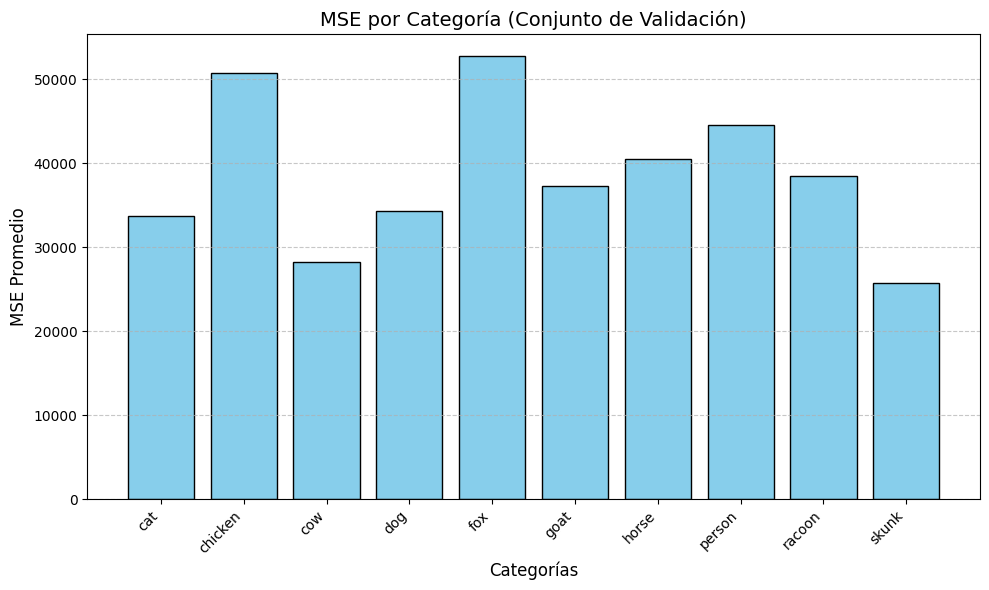

In [64]:
# Nombres de las categorías (asegúrate de que estén en el orden correcto)
class_names = ["cat", "chicken", "cow", "dog", "fox", "goat", "horse", "person", "racoon", "skunk"]

# Ordenar los resultados para que coincidan con los nombres de las clases
categories = class_names
mse_values = [mse_results[i] if i in mse_results else np.nan for i in range(num_classes)]

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
plt.bar(categories, mse_values, color='skyblue', edgecolor='black')

# Añadir etiquetas y título
plt.xlabel("Categorías", fontsize=12)
plt.ylabel("MSE Promedio", fontsize=12)
plt.title("MSE por Categoría (Conjunto de Validación)", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar la gráfica
plt.tight_layout()
plt.show()



calculo de matriz de confusion en la deteccion

In [68]:
print(f"Predicted boxes: {output.pred_boxes[0]}")
print(f"Predicted logits: {output.logits[0]}")


Predicted boxes: tensor([[5.8231e-02, 7.6167e-08, 1.0000e+00, 9.9316e-01],
        [9.5478e-07, 8.9792e-01, 9.9799e-01, 1.0000e+00],
        [4.6730e-04, 5.3237e-05, 9.9797e-01, 9.9186e-01],
        [3.6093e-03, 4.3178e-01, 4.0721e-01, 7.4015e-01],
        [9.9999e-01, 1.7914e-04, 1.0000e+00, 1.0000e+00],
        [9.9978e-01, 7.9286e-05, 1.0000e+00, 1.0000e+00],
        [9.9903e-01, 5.4903e-04, 1.0000e+00, 1.0000e+00],
        [1.0000e+00, 9.9975e-01, 1.0000e+00, 1.0000e+00],
        [9.9260e-01, 1.0000e+00, 1.0000e+00, 9.9996e-01],
        [3.1809e-01, 2.2204e-07, 9.9959e-01, 9.9545e-01],
        [4.5852e-02, 1.2086e-05, 9.8617e-01, 9.9920e-01],
        [1.0000e+00, 3.7888e-04, 1.0000e+00, 1.0000e+00],
        [2.0779e-05, 9.9995e-01, 1.0000e+00, 1.0000e+00],
        [1.0000e+00, 9.8561e-01, 1.0000e+00, 1.0000e+00],
        [7.7201e-07, 1.0000e+00, 1.0000e+00, 1.0000e+00],
        [1.8673e-02, 2.4950e-03, 9.2210e-01, 9.6073e-01],
        [9.9994e-01, 4.4383e-01, 1.0000e+00, 1.0000e+00

In [53]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)


vit.embeddings.cls_token True
vit.embeddings.detection_tokens True
vit.embeddings.position_embeddings True
vit.embeddings.patch_embeddings.projection.weight True
vit.embeddings.patch_embeddings.projection.bias True
vit.encoder.layer.0.attention.attention.query.weight True
vit.encoder.layer.0.attention.attention.query.bias True
vit.encoder.layer.0.attention.attention.key.weight True
vit.encoder.layer.0.attention.attention.key.bias True
vit.encoder.layer.0.attention.attention.value.weight True
vit.encoder.layer.0.attention.attention.value.bias True
vit.encoder.layer.0.attention.output.dense.weight True
vit.encoder.layer.0.attention.output.dense.bias True
vit.encoder.layer.0.intermediate.dense.weight True
vit.encoder.layer.0.intermediate.dense.bias True
vit.encoder.layer.0.output.dense.weight True
vit.encoder.layer.0.output.dense.bias True
vit.encoder.layer.0.layernorm_before.weight True
vit.encoder.layer.0.layernorm_before.bias True
vit.encoder.layer.0.layernorm_after.weight True
vit.enc

In [56]:
all_train_labels = []
for images, targets in train_loader:
    for target in targets:
        all_train_labels.extend(target["labels"].cpu().numpy())
train_label_counts = Counter(all_train_labels)
print("Conteos de etiquetas en el conjunto de entrenamiento:", train_label_counts)


Conteos de etiquetas en el conjunto de entrenamiento: Counter({np.int64(8): 155, np.int64(2): 148, np.int64(3): 135, np.int64(7): 118, np.int64(6): 114, np.int64(4): 101, np.int64(1): 85, np.int64(9): 80, np.int64(5): 79, np.int64(10): 66})
